# 관련 패키지 설치

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3 
!pip install torch

!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 131 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 14.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595735 sha256=71b98c093da54efdf17a1c145324150a8771002e0f8599db558fdb1bc51db604
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.p

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
device = torch.device("cuda:0")

bertmodel, vocab = get_pytorch_kobert_model()

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


# 데이터셋 로드 및 정제

In [4]:
import pandas as pd
df = pd.read_csv('감정 분류 데이터셋.csv',encoding='cp949')
df = df.iloc[:, [1, 2]]
df2 = pd.read_excel('speech.xlsx')

In [5]:
df3 = df2.iloc[1:2000,[1,2]]
df3.columns=['대화', '감정']

In [6]:
df.loc[(df['1번 감정'] == "angry"), '1번 감정'] = 0 
df.loc[(df['1번 감정'] == "anger"), '1번 감정'] = 0  
df.loc[(df['1번 감정'] == "disgust"), '1번 감정'] = 0  
df.loc[(df['1번 감정'] == "fear"), '1번 감정'] = 0  
df.loc[(df['1번 감정'] == "sadness"), '1번 감정'] = 0  
df.loc[(df['1번 감정'] == "sad"), '1번 감정'] = 0  
df.loc[(df['1번 감정'] == "neutral"), '1번 감정'] = 1
df.loc[(df['1번 감정'] == "surprise"), '1번 감정'] = 1 
df.loc[(df['1번 감정'] == "happiness"), '1번 감정'] = 2
df.columns=['대화', '감정']

In [7]:
df3.loc[(df3['감정'] == "슬픔"), '감정'] = 0 
df3.loc[(df3['감정'] == "공포"), '감정'] = 0  
df3.loc[(df3['감정'] == "혐오"), '감정'] = 0  
df3.loc[(df3['감정'] == "분노"), '감정'] = 0   
df3.loc[(df3['감정'] == "부정"), '감정'] = 0   
df3.loc[(df3['감정'] == "중립"), '감정'] = 1
df3.loc[(df3['감정'] == "놀람"), '감정'] = 1
df3.loc[(df3['감정'] == "행복"), '감정'] = 2
df3.loc[(df3['감정'] == "긍정"), '감정'] = 2

In [8]:
df_test = pd.read_csv('emotion_labeling.csv', encoding='cp949')
df_test.loc[(df_test['감정'] == '공포'), '감정'] = 0
df_test.loc[(df_test['감정'] == '분노'), '감정'] = 0
df_test.loc[(df_test['감정'] == '슬픔'), '감정'] = 0
df_test.loc[(df_test['감정'] == '혐오'), '감정'] = 0
df_test.loc[(df_test['감정'] == '부정'), '감정'] = 0
df_test.loc[(df_test['감정'] == '놀람'), '감정'] = 1
df_test.loc[(df_test['감정'] == '중립'), '감정'] = 1
df_test.loc[(df_test['감정'] == '긍정'), '감정'] = 2

In [9]:
print(np.unique(df['감정']))
print(np.unique(df_test.감정))

[0 1 2]
[0 1 2]


In [10]:
train_df = pd.concat([df, df3])
test_df = df_test

In [11]:
train = []
for q, label in zip(train_df['대화'], train_df['감정'])  :
    data = []
    data.append(q)
    data.append(str(label))

    train.append(data)

In [12]:
test = []
for q, label in zip(test_df['대화'], test_df['감정'])  :
    data = []
    data.append(q)
    data.append(str(label))

    test.append(data)

In [13]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):
        transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

## KOBERT 모델 학습

In [14]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate = 5e-5

In [15]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test, 0, 1, tok, max_len, True, False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [16]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [17]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = 3, # softmax 사용 <- binary일 경우는 2
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)
      

In [18]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

In [19]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [20]:
# 옵티마이저 선언
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # softmax용 Loss Function 정하기 <- binary classification도 해당 loss function 사용 가능

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [21]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [22]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [23]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) # gradient clipping
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
  
    model.eval() # 평가 모드로 변경
    
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/278 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.1447136402130127 train acc 0.34375
epoch 1 batch id 201 loss 0.7096255421638489 train acc 0.6019900497512438
epoch 1 train acc 0.6195005534034311


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 1 test acc 0.6331885026737968


  0%|          | 0/278 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.0697158575057983 train acc 0.5
epoch 2 batch id 201 loss 0.6816656589508057 train acc 0.7409048507462687
epoch 2 train acc 0.7341545033204206


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 2 test acc 0.6839070855614974


  0%|          | 0/278 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.7961294054985046 train acc 0.6875
epoch 3 batch id 201 loss 0.7242685556411743 train acc 0.787002487562189
epoch 3 train acc 0.7787813018815717


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 3 test acc 0.6993649732620321


  0%|          | 0/278 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.6607657074928284 train acc 0.71875
epoch 4 batch id 201 loss 0.6955560445785522 train acc 0.8044154228855721
epoch 4 train acc 0.7996333702268954


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 4 test acc 0.6745487967914439


  0%|          | 0/278 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.6010778546333313 train acc 0.734375
epoch 5 batch id 201 loss 0.7187644839286804 train acc 0.8272699004975125
epoch 5 train acc 0.8240220323741008


  0%|          | 0/17 [00:00<?, ?it/s]

epoch 5 test acc 0.6976938502673797


# 감정 분류 및 점수 측정 함수

In [24]:
def classify_emotion(sentences):    # 감정 분류 함수

  unseen_values = pd.DataFrame([[sentences, 0]], columns = [['대화 내용', '감정']]).values
  test_set = BERTDataset(unseen_values, 0, 1, tok, max_len, True, False)
  test_input = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=5)

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_input):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    out = model(token_ids, valid_length, segment_ids)
    max_vals, max_indices = torch.max(out, 1)

    temp = max_indices.data.cpu().numpy()
    if temp == [0]:
      final_value = -1
    elif temp == [1]:
      final_value = 0
    else:
      final_value = 1   
      
  return final_value

In [25]:
# 예시문장
classify_emotion('생크림은 질색이야')

-1

In [26]:
'''
def (sent): #문장을 입력받는다
   각 문장에 대한 감정분류 실시
   x_1 = 첫 문장에 대한 감정 값 (0~2)
   x_2 = 바로 앞과 뒷 문장에 대한 감정 평균값 (0~2)
   x_3 = 한 대화 turn에 대한 감정 평균값 (0~2)
   X = x_1*0.4 + x_2*0.3 + x_3*0.3
  return X

  x값을 그래프로 그려서 흐름 파악 가능 (같은 흐름을 따라가는지) 
'''

'\ndef (sent): #문장을 입력받는다\n   각 문장에 대한 감정분류 실시\n   x_1 = 첫 문장에 대한 감정 값 (0~2)\n   x_2 = 바로 앞과 뒷 문장에 대한 감정 평균값 (0~2)\n   x_3 = 한 대화 turn에 대한 감정 평균값 (0~2)\n   X = x_1*0.4 + x_2*0.3 + x_3*0.3\n  return X\n\n  x값을 그래프로 그려서 흐름 파악 가능 (같은 흐름을 따라가는지) \n'

In [27]:
  def score(sentences_list): # 점수 측정 함수
    X = []
    for i in range(len(sentences_list)):
      
      x_1 = classify_emotion(sentences_list[i])

      if i == 0:
        x_2 = (classify_emotion(sentences_list[i]) + classify_emotion(sentences_list[i+1]))/2
      elif i == (len(sentences_list)-1):
        x_2 = (classify_emotion(sentences_list[i]) + classify_emotion(sentences_list[i-1]))/2
      else:
        x_2 = (classify_emotion(sentences_list[i]) + classify_emotion(sentences_list[i-1]) + classify_emotion(sentences_list[i+1]) )/3

      X_3 = 0
      for i in range(len(sentences_list)):
        temp = classify_emotion(sentences_list[i])
        X_3 = X_3 + temp

      x_3 = X_3 / len(sentences_list)
    
      x = x_1*0.4 + x_2*0.3 + x_3*0.3
      X.append(x)
    
    return(X)

# test data

In [28]:
sent_1 = ['끝나고 디저트 카페 어때요?',
        '그럼요~ 여기 쇼트케이크 진짜 맛있어요!',
        ' 아뇨,, 뭐 그냥 크게 걱정 안해요. ㅋㅋ 먹고 싶은 거 먹는 거죠 뭐',
        ' 그래요? 싫어하는 사람도 있구나, 그럼 초콜릿은요? 초콜릿 진짜 맛있어요!']

In [29]:
sent_2 = ['아.. 디저트요? 좀 곤란한데요.. 좋아하시나요?',
          '하아.. 저는 디저트로 뚱뚱해지는게 싫어요.. 그런 걱정 안하시나봐요..',
          '대단하시네요. 전 생크림은 질색이에요.',
          '초콜릿도 잘 안 먹어요..ㅠㅠ']

In [30]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
score_1 = score(sent_1)
score_1

[0.3, 0.65, 0.35, 0.7000000000000001]

In [33]:
score_2 = score(sent_2)
score_2

[-0.3, -0.75, -0.75, -0.3]

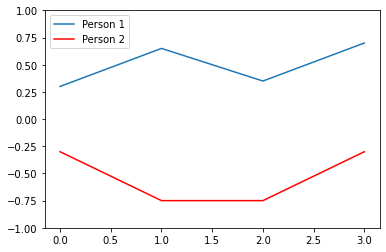

In [34]:
import matplotlib.pyplot as plt
plt.plot(score_1, label='Person 1')
plt.plot(score_2, color='red', label='Person 2')
plt.ylim(-1, 1)
plt.legend()
plt.show()

In [36]:
sent_3 = ['오늘 저녁 뭐 드셨어요?',
      '와~ 맛있으셨나요?',
      '저는 로제 떡볶이 먹어본 적 없어요.. 어떤 맛인가요?',
      '네 궁금하네요 ㅋㅋㅋ 한번 먹어봐야겠어요!',
      '전 김치찌개 먹었어요! 저는 저희 집 김치찌개가 젤 맛있는 것 같아요 ㅋㅋ',
      '저는 참치 넣는 것 좋아해요',
      '엄마표가 최고에요 진짜 ㅋㅋ']

In [41]:
sent_4 = ['오늘은 떡군이네 떡볶이라는 곳에서 로제 떡볶이 시켜 먹었어요.',
          '네 맛있더라고요. 한창 유행일 때는 잘 안 먹엇는데, 뒤늦게 자주 먹고 있어요.',
          '약간 떡 같은데 좀 더 쫄깃한 맛이에요. 나중에 한번 드셔보세요.',
          '꼭 배민에서 시켜 드세요. 거기꺼가 맛있어요. ㅋㅋ 혹시 저녁 뭐 드셨나요?',
          '역시 김치찌개 맛있죠! 뭐 넣어 드시는 거 좋아하세요?',
          '저희 엄마도 참치 좋아하셔서 언제나 참치 김치찌개에요.',
          '그렇죠 ㅋㅋ']

In [38]:
score_3 = score(sent_3)
score_3

[0.2785714285714286,
 0.6285714285714286,
 0.22857142857142854,
 0.22857142857142854,
 0.6285714285714286,
 0.3285714285714285,
 0.6785714285714286]

In [42]:
score_4 = score(sent_4)
score_4

[0.2357142857142857,
 0.5857142857142857,
 0.1857142857142857,
 0.1857142857142857,
 0.5857142857142857,
 0.1857142857142857,
 0.0857142857142857]

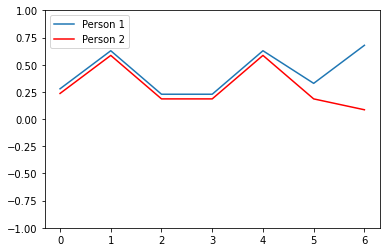

In [43]:
import matplotlib.pyplot as plt
plt.plot(score_3, label='Person 1')
plt.plot(score_4, color='red', label='Person 2')
plt.ylim(-1, 1)
plt.legend()
plt.show()

# 유사도 계산

In [44]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A, B):
  return dot(A, B)/(norm(A)*norm(B))

In [45]:
cos_sim(score_1, score_2)

-0.8665782448262422

In [46]:
cos_sim(score_3, score_4)

0.8778505126639583

In [47]:
def euclidean(x, y):
  x = np.array(x)
  y = np.array(y)
  return np.sqrt(np.sum((x-y)**2))

In [48]:
euclidean(score_1, score_2)

2.1283796653792764

In [49]:
euclidean(score_3, score_4)

0.6173098319089277

In [ ]:
# 전체적으로는 긍정의 감정을 나타내도 중간중간 중립의 감정을 드러내는 문장이 존재